In [9]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('HSBC.csv')

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Filtering the dataset for the year 2023
start_date = '2023-01-01'
end_date = '2023-12-31'
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df_2023 = df.loc[mask]

# Display the first few rows to understand its structure
df_2023.head()

,Date,Open,High,Low,Close,Adj Close,Volume,R3,S3
8859,2023-01-03,518.099976,531.700012,515.700012,529.900024,489.840240,33285725,534.300024,525.500024
8860,2023-01-04,535.099976,544.799988,532.500000,543.500000,502.412018,21604090,546.882497,540.117503
8861,2023-01-05,548.000000,568.400024,545.398987,565.299988,522.564026,36654670,571.625273,558.974703
8862,2023-01-06,566.000000,569.849976,559.599976,568.599976,525.614563,31225164,571.418726,565.781226
8863,2023-01-09,564.500000,566.799988,561.599976,563.200012,520.622803,23530081,564.630015,561.770009


In [10]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Selecting the features for the model
features = df_2023[['Close', 'R3', 'S3']]

# Scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Function to create sequences for LSTM input
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length, 0])  # Target is the 'Close' price
    return np.array(x), np.array(y)

# Defining the sequence length (number of days to consider for making a prediction)
sequence_length = 20  # Let's use the past 20 days to predict the next day

# Creating sequences
X, y = create_sequences(scaled_features, sequence_length)

# Splitting the dataset into training and testing sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train.shape, X_test.shape

((184, 20, 3), (47, 20, 3))

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Initialize the Sequential model
model = Sequential([
    # First LSTM layer with Dropout
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),

    # Second LSTM Layer
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),

    # Output Layer
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# Train the model on the training data
history = model.fit(
    X_train, y_train,
    epochs=100,  # Number of iterations over the entire dataset to train on
    batch_size=32,  # Number of samples per gradient update
    validation_split=0.1,  # Fraction of the training data to be used as validation data
    verbose=1
)

Epoch 1/100
6/6 [==============================] - 2s 83ms/step - loss: 0.1218 - val_loss: 0.0332
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0677 - val_loss: 0.0337
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0354 - val_loss: 0.0649
Epoch 4/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0374 - val_loss: 0.0264
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0282 - val_loss: 0.0187
Epoch 6/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0263 - val_loss: 0.0211
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0256 - val_loss: 0.0264
Epoch 8/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0236 - val_loss: 0.0186
Epoch 9/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0226 - val_loss: 0.0144
Epoch 10/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0215 - val_loss: 0.0279
Epoch 11/100
6/6 [=

Epoch 84/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0092 - val_loss: 0.0090
Epoch 85/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0106 - val_loss: 0.0094
Epoch 86/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0096 - val_loss: 0.0065
Epoch 87/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0108 - val_loss: 0.0104
Epoch 88/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0097 - val_loss: 0.0058
Epoch 89/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0102 - val_loss: 0.0120
Epoch 90/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0089 - val_loss: 0.0066
Epoch 91/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0092 - val_loss: 0.0075
Epoch 92/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0088 - val_loss: 0.0122
Epoch 93/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0099 - val_loss: 0.0077
Epoch 94/1

In [13]:
# Function to make predictions into the future
def forecast_future_days(model, start_sequence, days_to_predict):
    prediction_list = start_sequence[-sequence_length:]
    
    for _ in range(days_to_predict):
        x = prediction_list[-sequence_length:]
        x = x.reshape((1, sequence_length, 3))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, [[out, 0, 0]], axis=0)  # Append prediction
        
    predicted_sequence = scaler.inverse_transform(prediction_list[sequence_length:])
    return predicted_sequence[:, 0]  # Return only the 'Close' price predictions

# Predict the next 30 days
next_10_days = forecast_future_days(model, scaled_features, 30)
next_10_days

1/1 [==============================] - 0s 10ms/step


array([624.97876605, 607.47742235, 588.68674223, 572.6507956 ,
       560.25671301, 551.2015459 , 544.9499839 , 540.84350789,
       538.36639311, 537.04897924, 536.54837074, 536.59160054,
       536.98272324, 537.54355007, 538.17611507, 538.80286172,
       539.37353329, 539.86148598, 540.26170268, 540.56694821,
       540.77687629, 541.10261252, 541.35725408, 541.55481732,
       541.70709958, 541.82348487, 541.91140553, 541.97678382,
       542.02440215, 542.05813973])

2/2 [==============================] - 0s 3ms/step


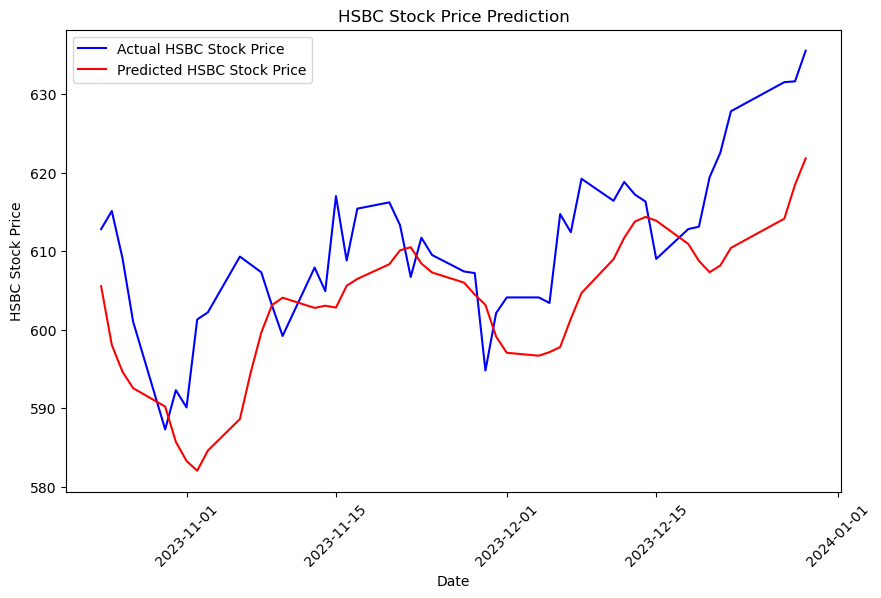

In [14]:
import matplotlib.pyplot as plt

actual_prices = df_2023['Close'].values[-len(y_test):]  # Last part of the actual prices for the test set
predicted_prices = model.predict(X_test)  # Predictions made by model on the test set
predicted_prices_reshaped = predicted_prices.reshape(-1, 1)  # Reshaping predicted_prices to match the shape expected by the scaler

# Inverse transform using the scaler
corrected_predicted_prices = scaler.inverse_transform(np.hstack((predicted_prices_reshaped, np.zeros((len(predicted_prices_reshaped), 2)))))[:, 0]

# Extract dates for the test set
test_dates = df_2023['Date'].values[-len(y_test):]

# Plotting the actual vs predicted prices with dates on x-axis
plt.figure(figsize=(10, 6))
plt.plot(test_dates, actual_prices, color='blue', label='Actual HSBC Stock Price')
plt.plot(test_dates, corrected_predicted_prices, color='red', label='Predicted HSBC Stock Price')
plt.title('HSBC Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('HSBC Stock Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [15]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Calculate MAPE given the actual and predicted values.
    
    :param y_true: The actual values
    :param y_pred: The predicted values
    :return: MAPE as a percentage
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Assuming `actual_prices` are the actual Close prices and `corrected_predicted_prices` are the predicted Close prices from model
mape = mean_absolute_percentage_error(actual_prices, corrected_predicted_prices)

print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")


MAPE (Mean Absolute Percentage Error): 1.39%


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual_prices, corrected_predicted_prices)
mse = mean_squared_error(actual_prices, corrected_predicted_prices)
rmse = np.sqrt(mse)  # RMSE is the square root of MSE

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 8.488611431297498
Mean Squared Error (MSE): 103.48061492665343
Root Mean Squared Error (RMSE): 10.172542205695361


In [ ]:
corrected_predicted_prices